### Some notes
- sub-CC00657XX14 had two scans, one at age 29.85 and one at age 41. The earlier scan had a radiology score of 1 and the latter had a score of 3 (Incidental findings with unlikely clinical significance but possible analysis significance)

### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.distributions as dist
from torchsummary import summary
import math
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import re

from importlib import reload
import visualization

# locals
import model_architectures

reload(model_architectures)
from model_architectures import VAE, Data3D

reload(visualization)
from visualization import brain_diff

C:\compute\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Paths

In [2]:
research_dir = r"D:/school/research"
code_dir = os.path.join(research_dir, "code")
model_dir = os.path.join(code_dir, "explore_again", "models")
data_dir = os.path.join(research_dir, "data")
dhcp_rel2 = os.path.join(data_dir, "dhcp_rel2")
processed_dir = os.path.join(dhcp_rel2, "processed")
volume_dir = os.path.join(processed_dir, "volumes")
l1_dir = os.path.join(volume_dir, "l1")
l5_dir = os.path.join(volume_dir, "l5")

### Get Data

In [3]:
np.random.seed(42)
num_samples = int(len(os.listdir(l1_dir)) / 2)
samples = np.array([i for i in range(0, num_samples)])
np.random.shuffle(samples)

split_val = int(0.8 * num_samples)
train_indices = samples[0:split_val]
val_indices = samples[split_val:]

num_test = int(len(os.listdir(l5_dir)) / 2)
test_indices = np.array([i for i in range(0, num_test)])

In [4]:
train = Data3D(l1_dir, train_indices, t1_only=True)
val = Data3D(l1_dir, val_indices, t1_only=True)
test = Data3D(l5_dir, test_indices, t1_only=True)

batch_size = 1
train_loader = DataLoader(train, batch_size=batch_size)#, num_workers=1)
val_loader = DataLoader(val, batch_size=batch_size)#, num_workers=1)

### Quick Visualization

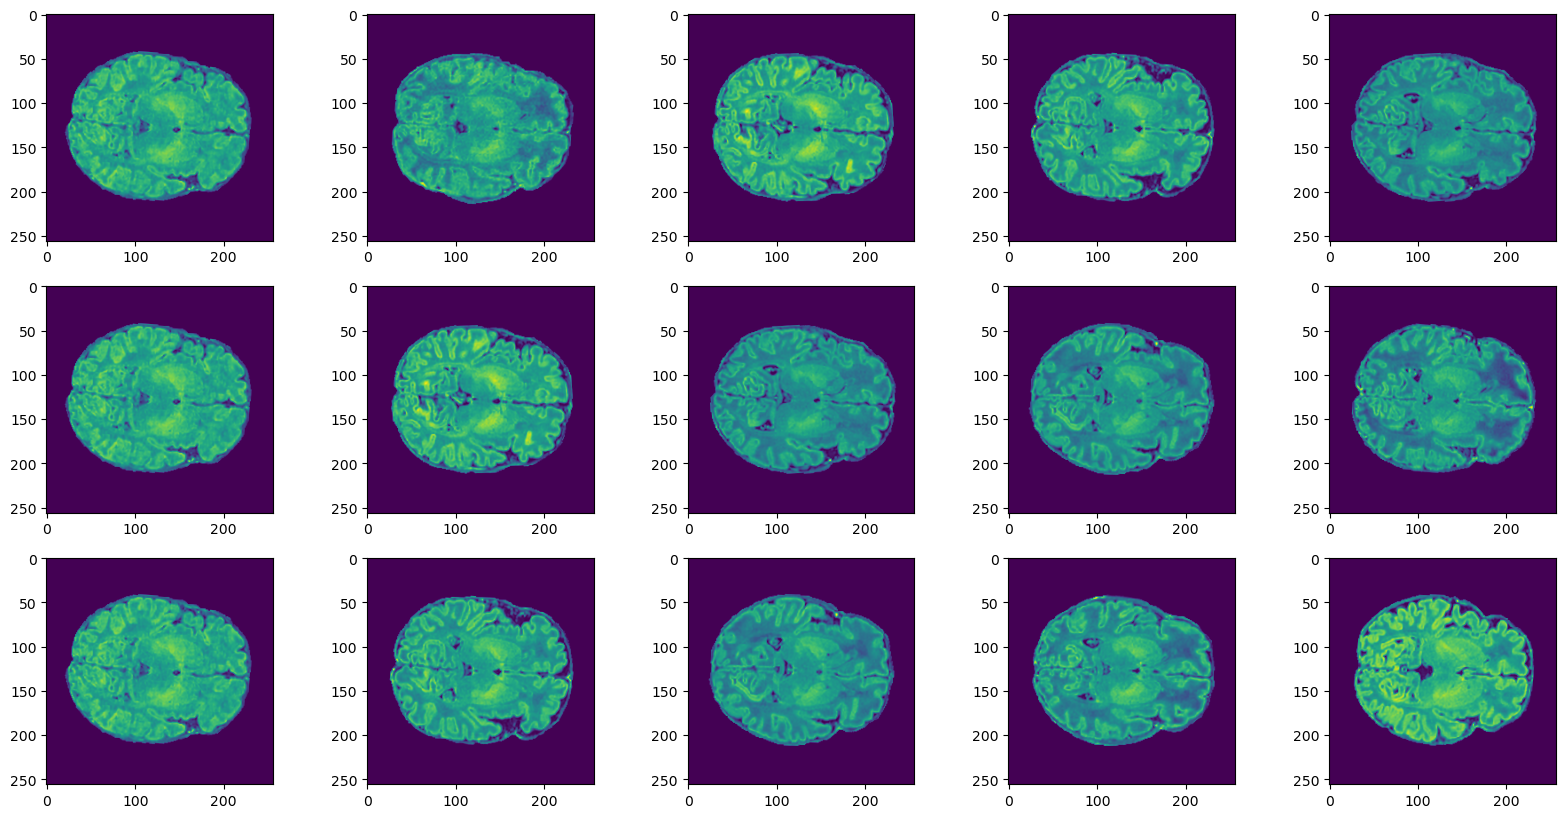

In [5]:
%matplotlib inline

f, axarr = plt.subplots(3, 5, figsize=(20, 10))
cmap = plt.get_cmap('viridis')

for r in range(0,3):
    for i in range(0, 5):
        z = math.ceil(train[i*(r+1)][0].shape[2]/2)
        axarr[r][i].imshow(train[i*(r+1)][0][:,:,z], cmap=cmap)

### T2 VAE

In [14]:
model = VAE(1)
# summary(model.cuda(), (1, 256, 256, 256))


# model = nn.DataParallel(model)
model.cuda()
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-07)

num_epochs = 100
# this works for batch size of 128, c=1
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(train_loader, unit="batch", ascii=' >=') as tepoch:
        model.train()
        data_counter = 0
        for data in tepoch:
            # clear gradients
            optimizer.zero_grad()
            
            # forward
            x = data.cuda()
            output = model(x)
            loss = criterion(x, output)
            
            # backward
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data
            data_counter += 1
        ## This is probably more memory efficient but doesn't appear necessary in this case
        # del x
        # del output
        # torch.cuda.empty_cache()
        
        total_loss /= data_counter
            
        tepoch.set_postfix(loss=loss.item())
        val_loss = 0
        model.eval()
        data_counter = 0
        for data in val_loader:
            with torch.no_grad():
                x = data.cuda()
                output = model(x)
                loss = criterion(x, output)

                val_loss += loss.data
                data_counter += 1
        
        val_loss /= data_counter
        
        print('epoch [{}/{}], train_loss:{:.4f}, val_loss:{:.4f}'
              .format(epoch+1, num_epochs, total_loss, val_loss))

100%|=============================================================================| 166/166 [00:56<00:00,  2.94batch/s]


epoch [1/100], train_loss:0.0869, val_loss:0.0055


100%|=============================================================================| 166/166 [00:51<00:00,  3.22batch/s]


epoch [2/100], train_loss:0.0056, val_loss:0.0064


100%|=============================================================================| 166/166 [00:51<00:00,  3.22batch/s]


epoch [3/100], train_loss:0.0051, val_loss:0.0088


100%|=============================================================================| 166/166 [00:51<00:00,  3.21batch/s]


epoch [4/100], train_loss:0.0048, val_loss:0.0093


100%|=============================================================================| 166/166 [00:51<00:00,  3.20batch/s]


epoch [5/100], train_loss:0.0047, val_loss:0.0091


100%|=============================================================================| 166/166 [00:51<00:00,  3.20batch/s]


epoch [6/100], train_loss:0.0047, val_loss:0.0085


100%|=============================================================================| 166/166 [00:51<00:00,  3.20batch/s]


epoch [7/100], train_loss:0.0046, val_loss:0.0076


100%|=============================================================================| 166/166 [00:51<00:00,  3.20batch/s]


epoch [8/100], train_loss:0.0046, val_loss:0.0066


100%|=============================================================================| 166/166 [00:53<00:00,  3.11batch/s]


epoch [9/100], train_loss:0.0045, val_loss:0.0057


100%|=============================================================================| 166/166 [00:53<00:00,  3.11batch/s]


epoch [10/100], train_loss:0.0045, val_loss:0.0051


100%|=============================================================================| 166/166 [00:52<00:00,  3.18batch/s]


epoch [11/100], train_loss:0.0044, val_loss:0.0047


100%|=============================================================================| 166/166 [00:52<00:00,  3.18batch/s]


epoch [12/100], train_loss:0.0044, val_loss:0.0045


100%|=============================================================================| 166/166 [00:52<00:00,  3.15batch/s]


epoch [13/100], train_loss:0.0044, val_loss:0.0043


100%|=============================================================================| 166/166 [00:52<00:00,  3.17batch/s]


epoch [14/100], train_loss:0.0043, val_loss:0.0043


100%|=============================================================================| 166/166 [00:53<00:00,  3.12batch/s]


epoch [15/100], train_loss:0.0043, val_loss:0.0041


100%|=============================================================================| 166/166 [00:52<00:00,  3.16batch/s]


epoch [16/100], train_loss:0.0043, val_loss:0.0041


100%|=============================================================================| 166/166 [00:52<00:00,  3.18batch/s]


epoch [17/100], train_loss:0.0043, val_loss:0.0041


100%|=============================================================================| 166/166 [00:52<00:00,  3.15batch/s]


epoch [18/100], train_loss:0.0042, val_loss:0.0040


100%|=============================================================================| 166/166 [00:51<00:00,  3.20batch/s]


epoch [19/100], train_loss:0.0042, val_loss:0.0040


100%|=============================================================================| 166/166 [00:50<00:00,  3.27batch/s]


epoch [20/100], train_loss:0.0042, val_loss:0.0040


100%|=============================================================================| 166/166 [00:50<00:00,  3.26batch/s]


epoch [21/100], train_loss:0.0041, val_loss:0.0039


100%|=============================================================================| 166/166 [00:50<00:00,  3.26batch/s]


epoch [22/100], train_loss:0.0041, val_loss:0.0039


100%|=============================================================================| 166/166 [00:51<00:00,  3.24batch/s]


epoch [23/100], train_loss:0.0041, val_loss:0.0041


  8%|======                                                                        | 13/166 [00:04<00:48,  3.14batch/s]


KeyboardInterrupt: 

### Save Model

In [15]:
model_path = os.path.join(model_dir, "vae_rel2_t1_second_session.pt")
torch.save(model.state_dict(), model_path)

### Load Model

In [5]:
model_path = os.path.join(model_dir, "vae_rel2_t1_second_session.pt")
model = VAE(1)
model.load_state_dict(torch.load(model_path))
model.cuda()
model.eval()

VAE(
  (model): Sequential(
    (0): ResnetEncoder(
      (pass1): Sequential(
        (0): InstanceNorm3d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (1): ReLU()
        (2): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (pass2): Sequential(
        (0): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (1): ReLU()
        (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (conv_bypass): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(4, 4, 4))
      (activation_bypass): ReLU()
    )
    (1): ResnetEncoder(
      (pass1): Sequential(
        (0): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (1): ReLU()
        (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (pass2): Sequential(
        (0): InstanceNorm3d(32, eps=1e-05, momentum=0.1, aff

### Explore Losses

In [32]:
%%time
criterion = nn.MSELoss()

train_losses = []
for img in train:
    x = torch.Tensor(np.reshape(img, (1, 1, 256, 256, 256))).cuda()
    output = model(x)
    train_losses.append(float(criterion(x, output).cpu()))   

CPU times: total: 27.4 s
Wall time: 27.4 s


In [28]:
%%time
val_losses = []
for img in val:
    x = torch.Tensor(np.reshape(img, (1, 1, 256, 256, 256))).cuda()
    output = model(x)
    val_losses.append(float(criterion(x, output).cpu()))   

CPU times: total: 6.86 s
Wall time: 6.87 s


In [29]:
%%time
test_losses = []
for img in test:
    x = torch.Tensor(np.reshape(img, (1, 1, 256, 256, 256))).cuda()
    output = model(x)
    test_losses.append(float(criterion(x, output).cpu()))   

CPU times: total: 4.48 s
Wall time: 4.6 s


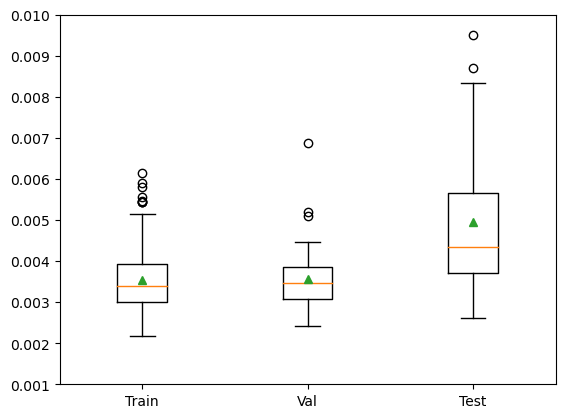

In [34]:
plt.ylim(0.001, 0.01)
bp = plt.boxplot(
    [train_losses, val_losses, test_losses],
    vert=True,
    labels=['Train', 'Val', 'Test'],
    showfliers=True,
    showmeans=True
)
# 

(array([19., 74., 51., 17.,  4.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00217736, 0.00305293, 0.00392851, 0.00480409, 0.00567967,
        0.00655524, 0.00743082, 0.0083064 , 0.00918197, 0.01005755,
        0.01093313]),
 <BarContainer object of 10 artists>)

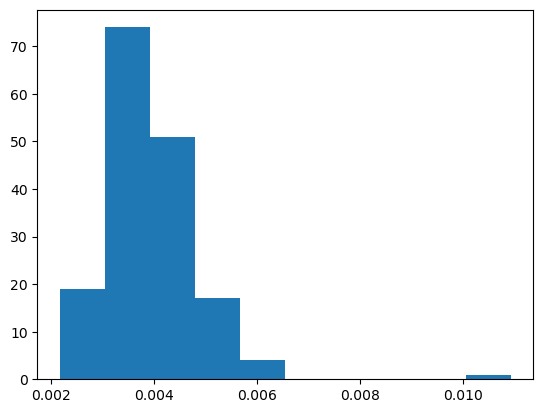

In [20]:
plt.hist(train_losses)

remaining samples:  132


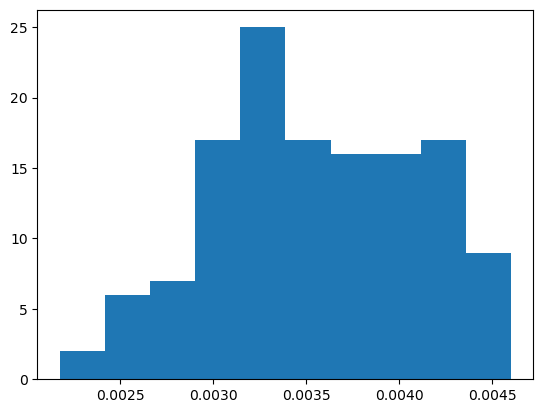

In [48]:
sorted_losses = sorted([(x, y) for x, y in enumerate(train_losses)], key=lambda x: x[1])
num_samples = int(len(sorted_losses) * 0.8)
print("remaining samples: ", num_samples)
reduced_losses = sorted_losses[0:num_samples]
res = plt.hist([x[1] for x in reduced_losses])

(array([ 3.,  0.,  6.,  6.,  3.,  8.,  9., 11., 17., 21.]),
 array([0.00681723, 0.00711648, 0.00741573, 0.00771498, 0.00801423,
        0.00831347, 0.00861272, 0.00891197, 0.00921122, 0.00951047,
        0.00980972]),
 <BarContainer object of 10 artists>)

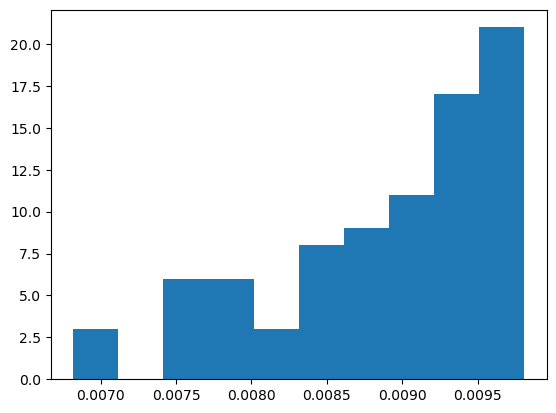

In [57]:
sorted_losses = sorted(train_losses)
reduced = losses[0:int(len(sorted_losses) * 0.5)]
plt.hist(reduced)

(-0.5, 255.5, 255.5, -0.5)

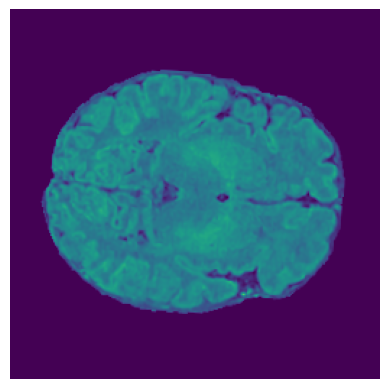

In [9]:
index = 0
x = torch.Tensor(np.reshape(train[index], (1, 1, 256, 256, 256))).cuda()
output = model(x)

og = np.reshape(x.cpu().detach().numpy(), (256, 256, 256))
pred = np.reshape(output.cpu().detach().numpy(), (256, 256, 256))

s = 128
plt.imshow(og[:,:,s], vmin=0, vmax=1)
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

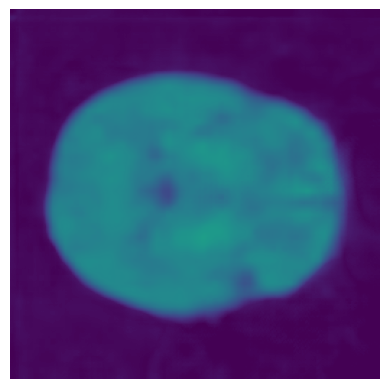

In [10]:
plt.imshow(pred[:,:,s], vmin=0, vmax=1)
plt.axis('off')

### Train Visualization

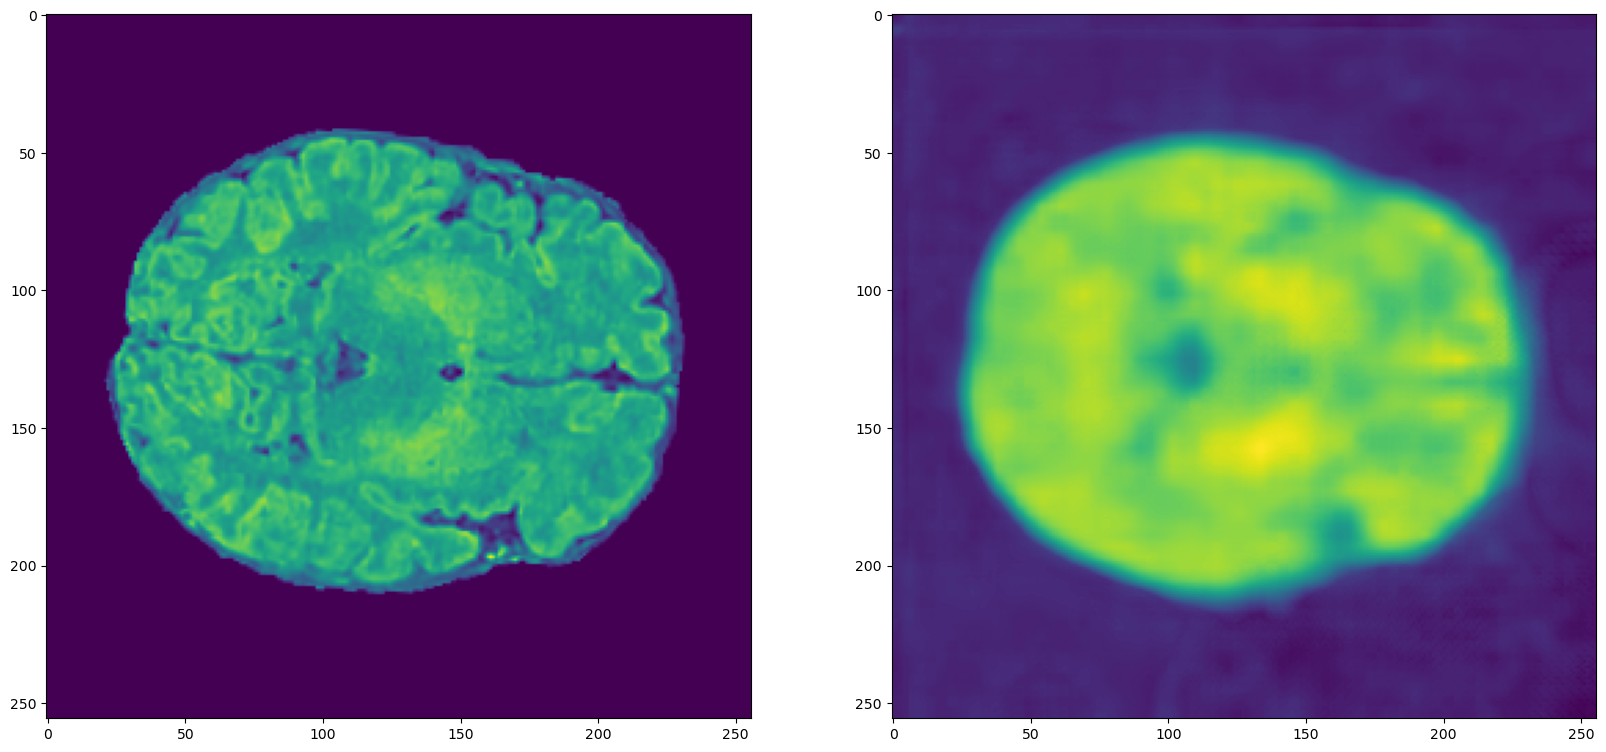

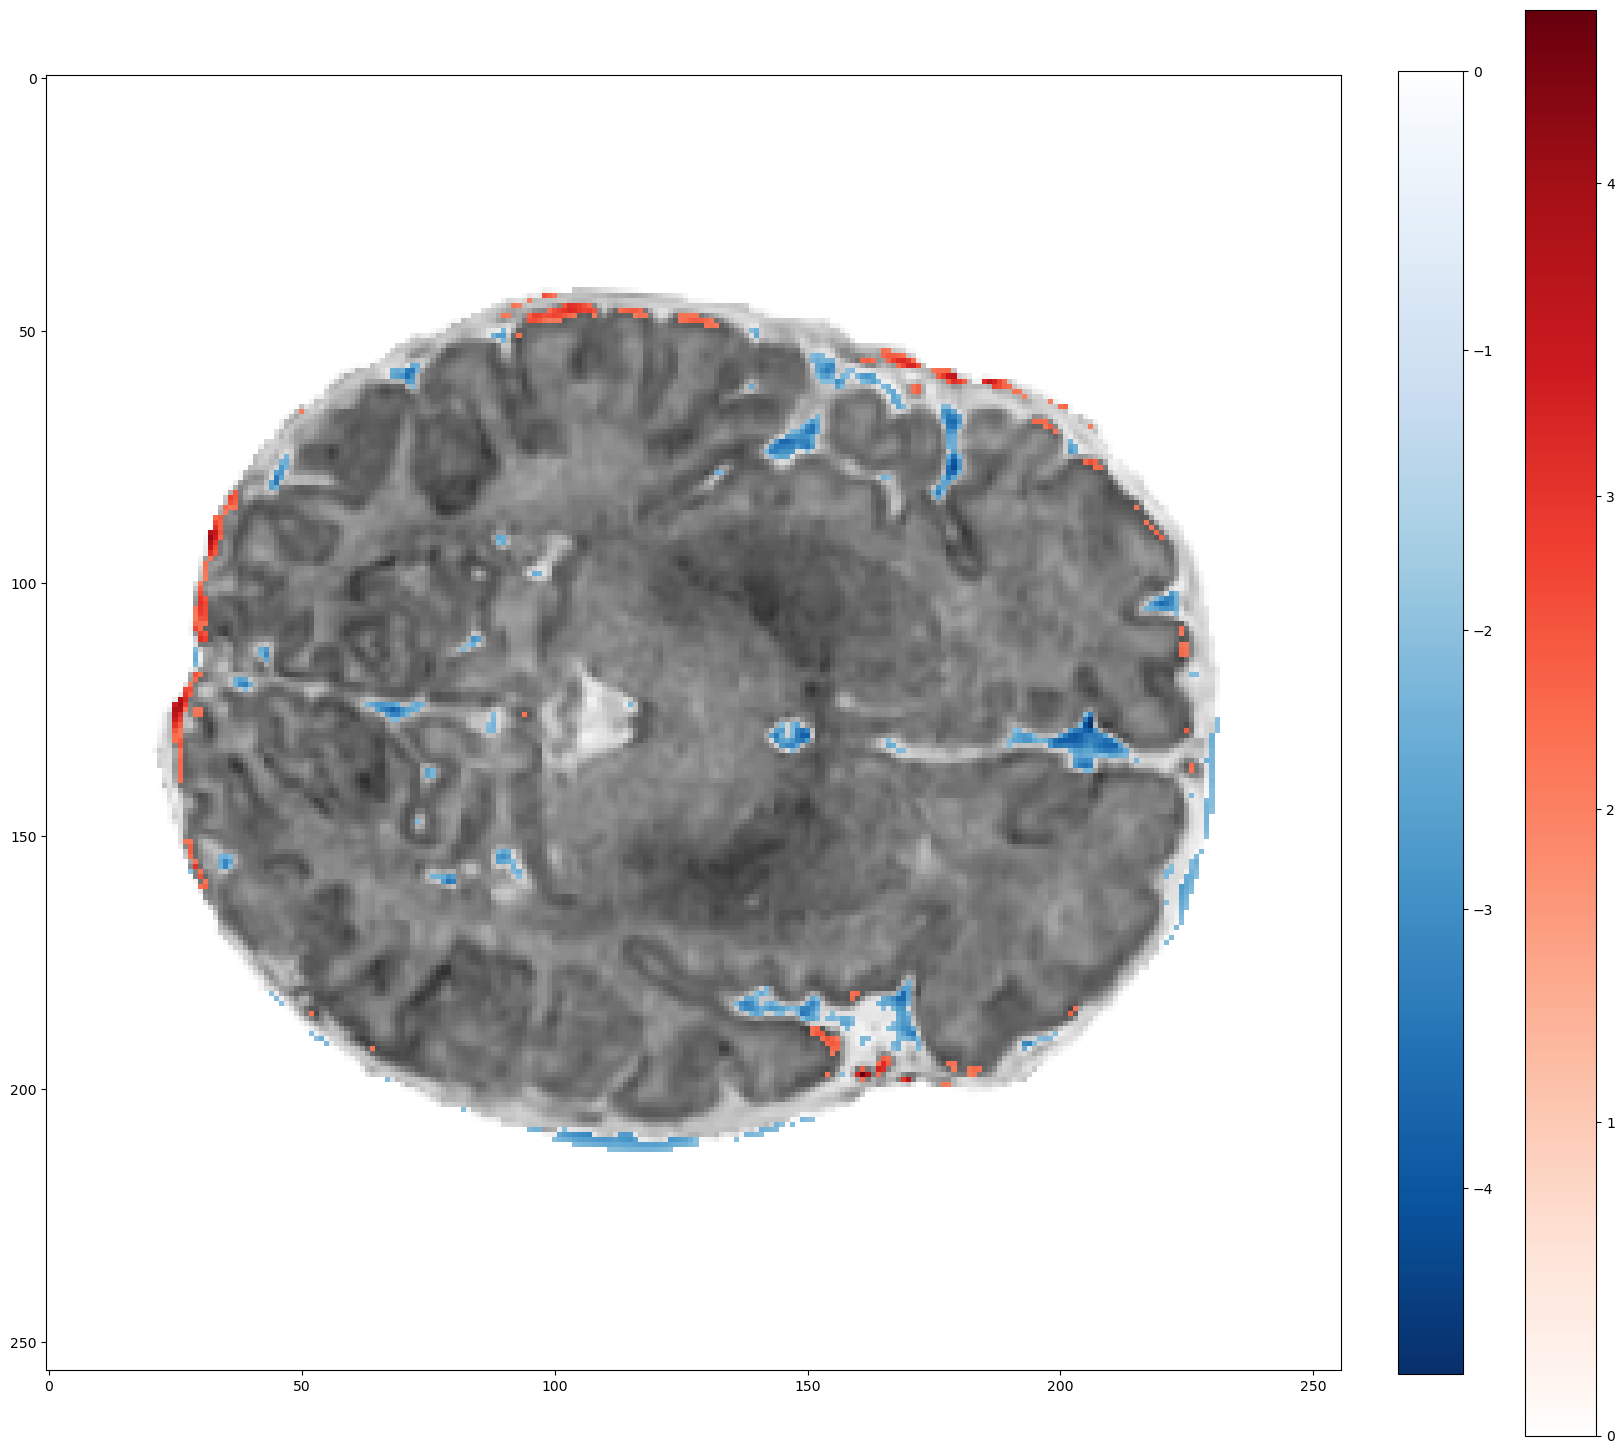

In [16]:
index = 0
x = torch.Tensor(np.reshape(train[index], (1, 1, 256, 256, 256))).cuda()
output = model(x)

og = np.reshape(x.cpu().detach().numpy(), (256, 256, 256))
pred = np.reshape(output.cpu().detach().numpy(), (256, 256, 256))

s = 128
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(og[:,:,s])
ax[1].imshow(pred[:,:,s])

brain_diff(og[:,:,s], pred[:,:,s], threshold=2)

### Val Visualization

D:\school\research\code\explore_again\modeling\multimodal\visualization.py:92: UserWarning: Trying to register the cmap 'above_mean' which already exists.
  plt.register_cmap(cmap=map_object)
D:\school\research\code\explore_again\modeling\multimodal\visualization.py:99: UserWarning: Trying to register the cmap 'below_mean' which already exists.
  plt.register_cmap(cmap=map_object)


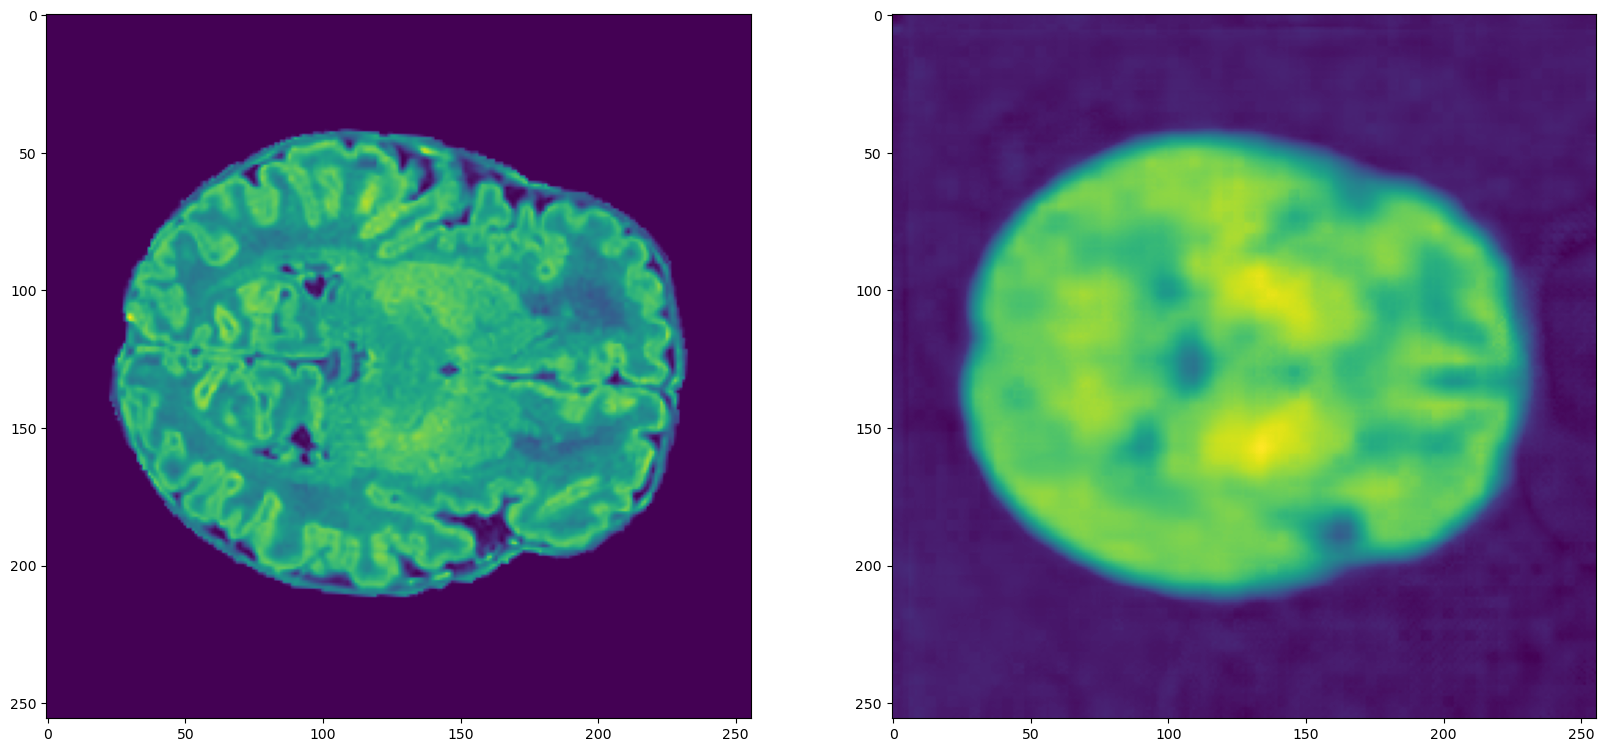

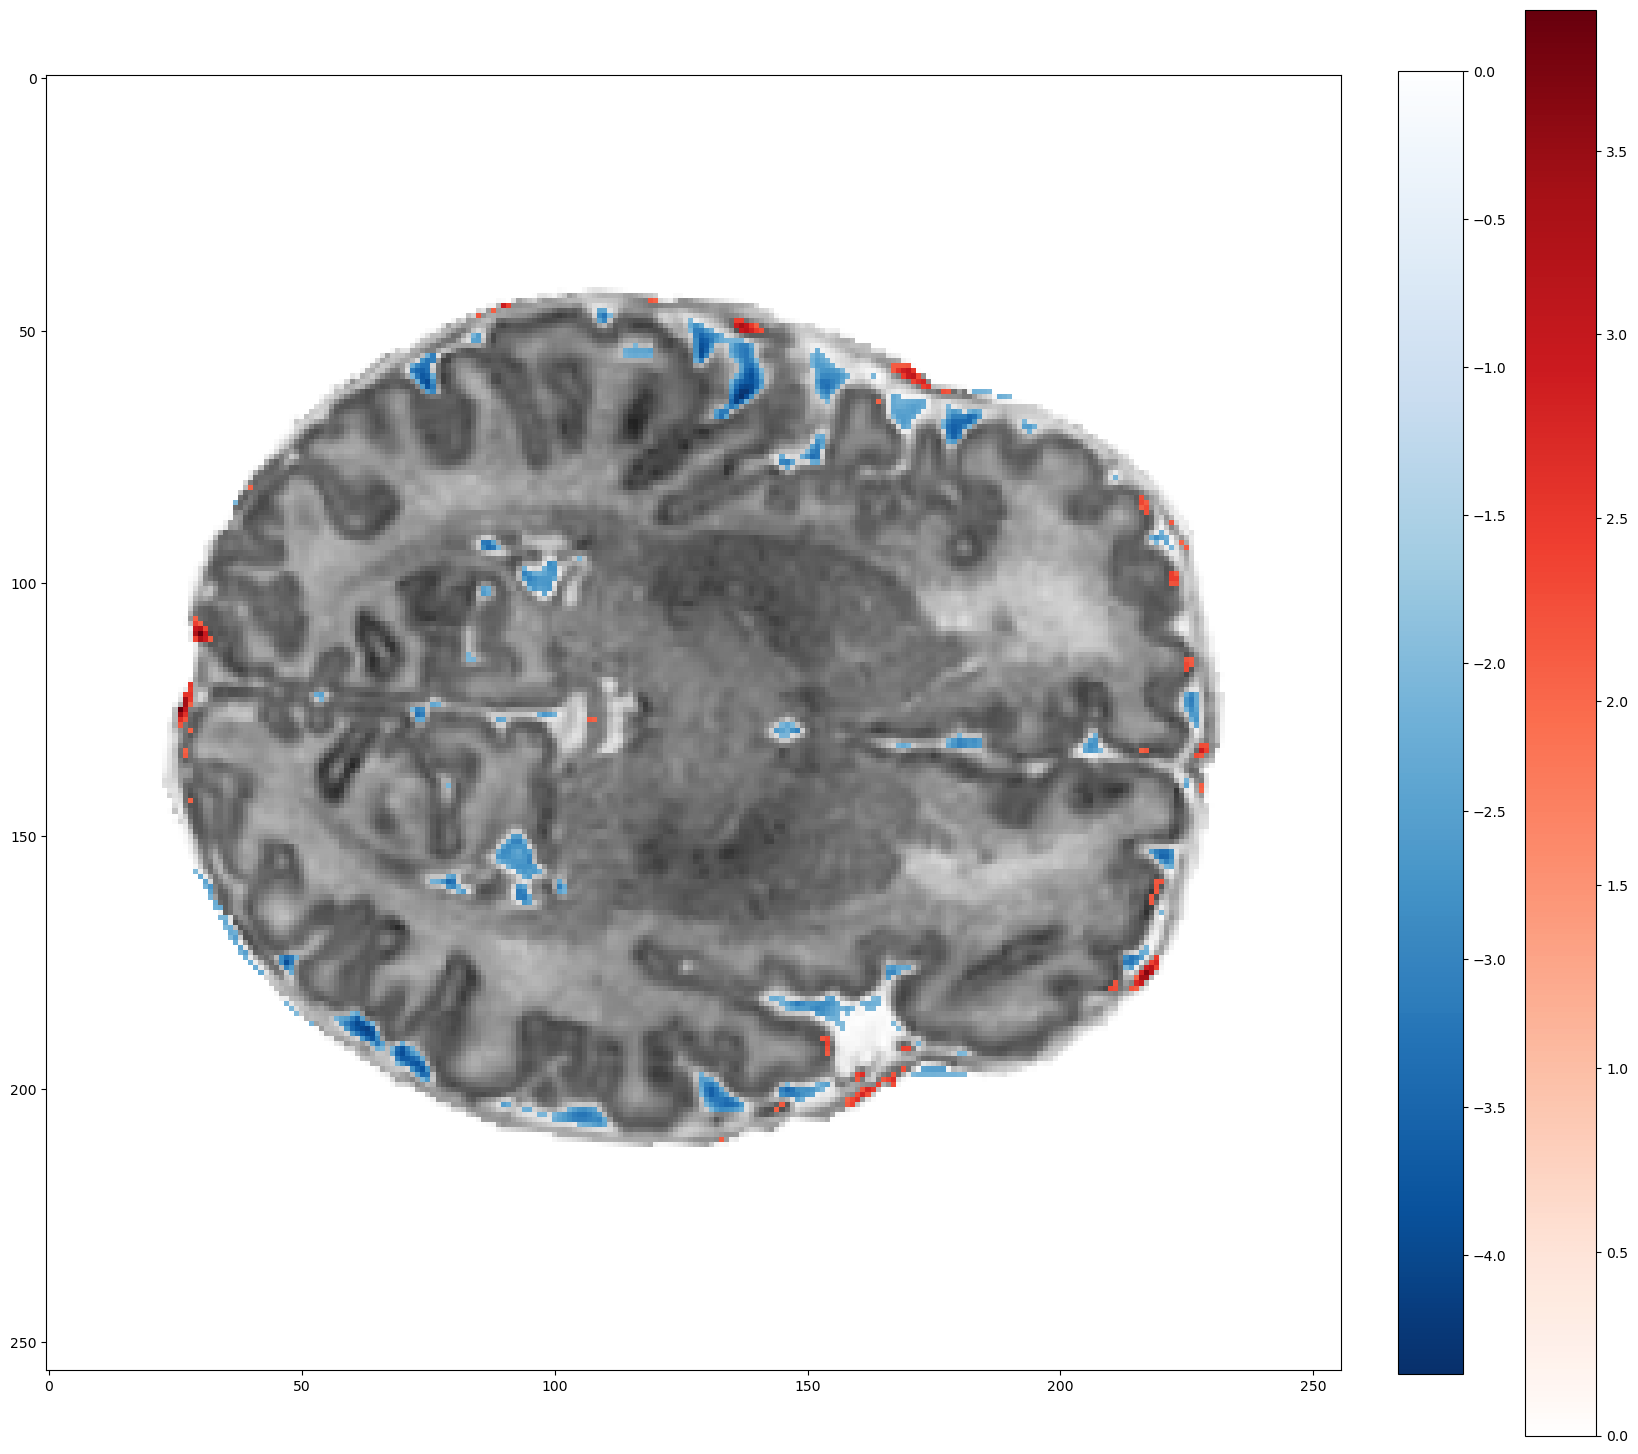

In [17]:
index = 1
x = torch.Tensor(np.reshape(val[index], (1, 1, 256, 256, 256))).cuda()
output = model(x)

og = np.reshape(x.cpu().detach().numpy(), (256, 256, 256))
pred = np.reshape(output.cpu().detach().numpy(), (256, 256, 256))

s = 128
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(og[:,:,s])
ax[1].imshow(pred[:,:,s])

brain_diff(og[:,:,s], pred[:,:,s], threshold=2)

### Test Visualization

tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward0>)


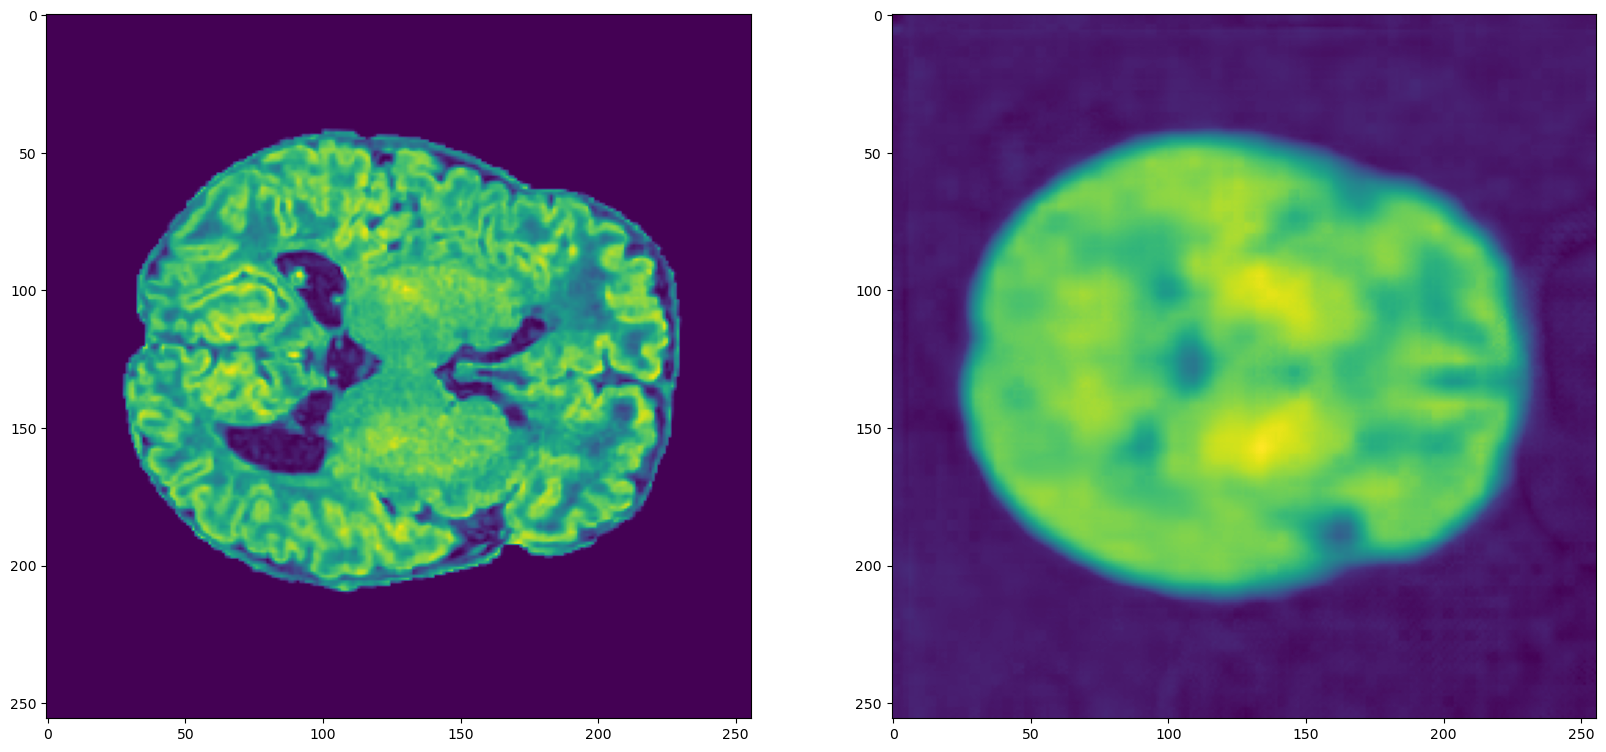

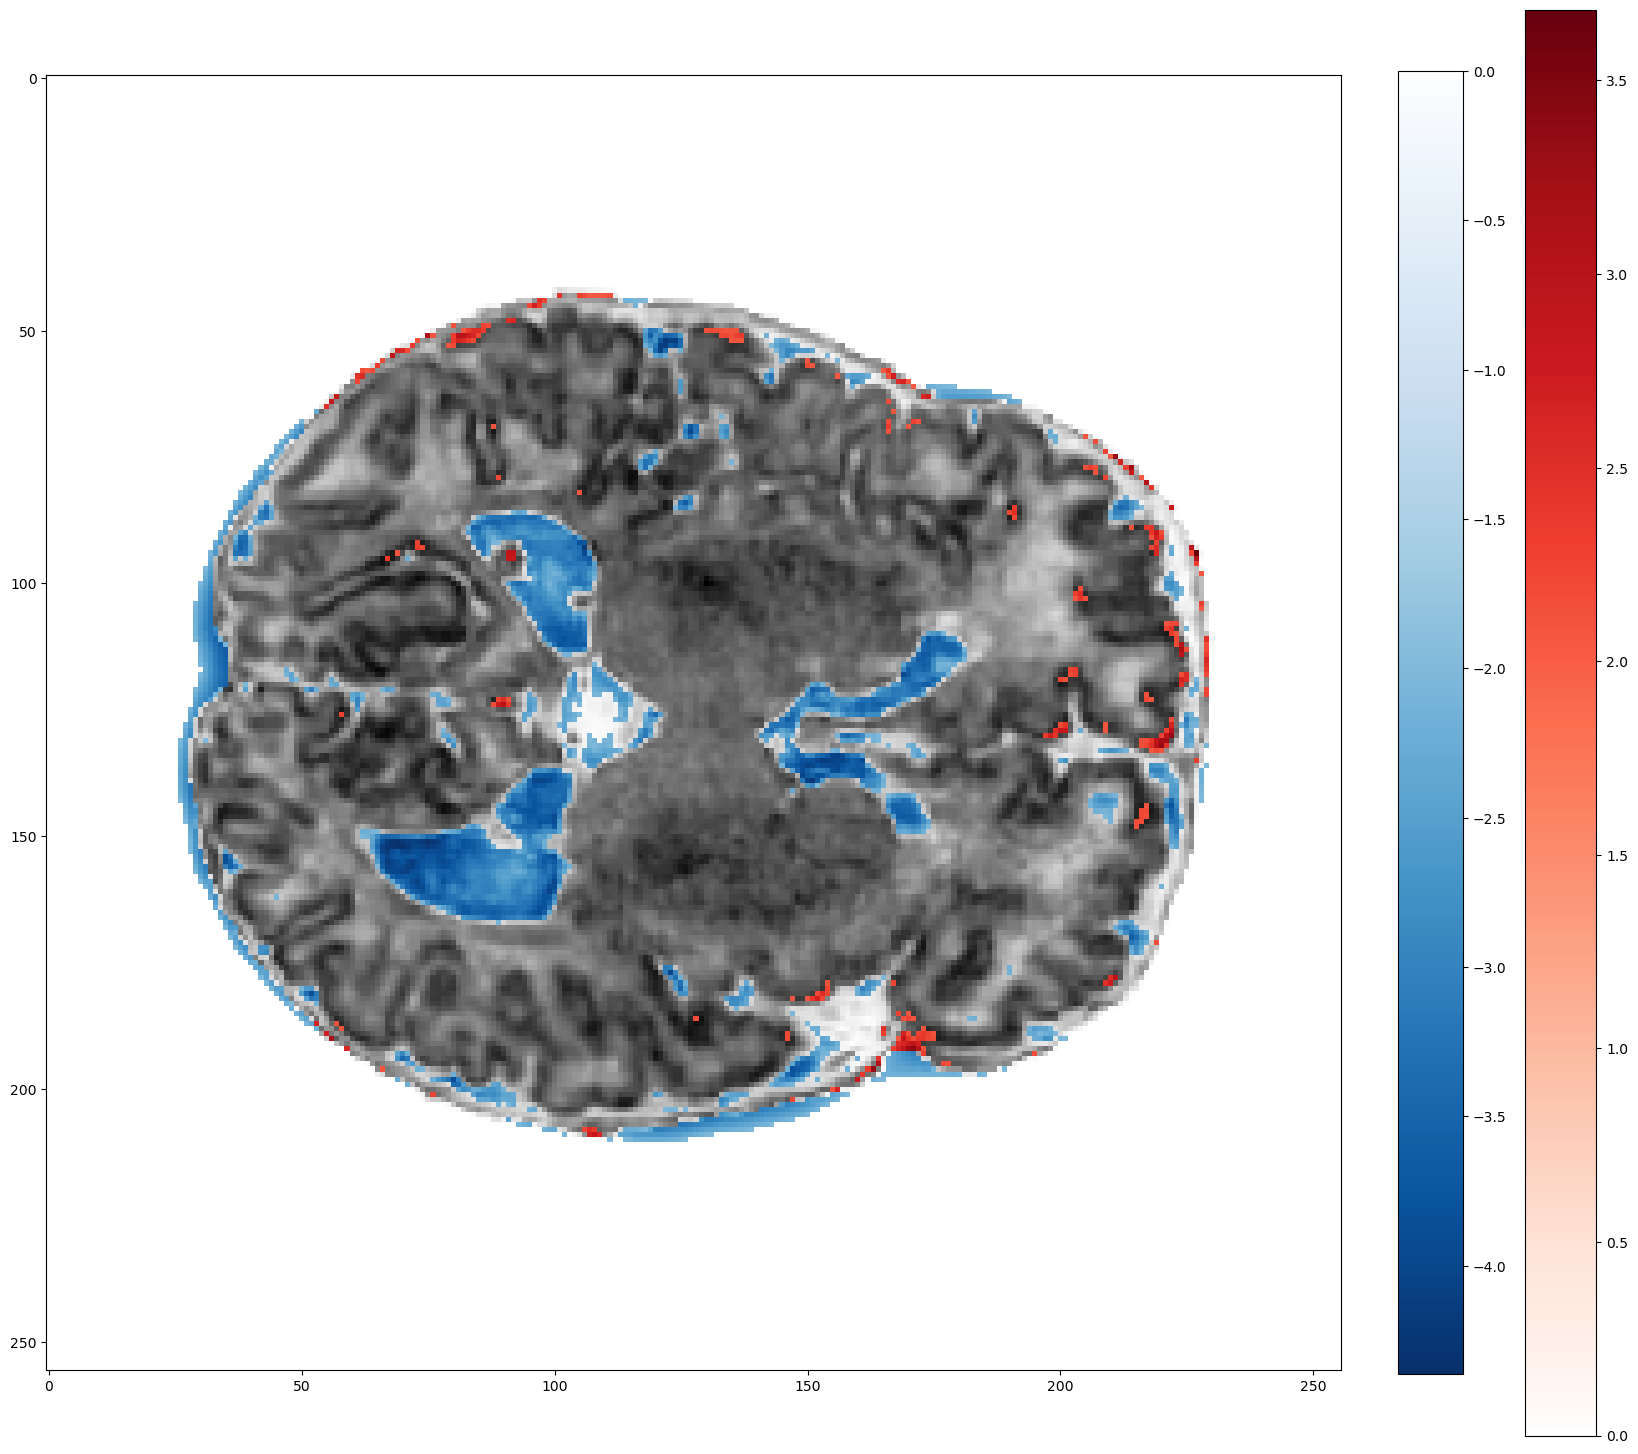

In [20]:
index = 0
x = torch.Tensor(np.reshape(test[index], (1, 1, 256, 256, 256))).cuda()
output = model(x)
print(criterion(x, output))

og = np.reshape(x.cpu().detach().numpy(), (256, 256, 256))
pred = np.reshape(output.cpu().detach().numpy(), (256, 256, 256))

s = 128
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(og[:,:,s])
ax[1].imshow(pred[:,:,s])

brain_diff(og[:,:,s], pred[:,:,s], threshold=2)